In [173]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes

import dwave_networkx as dnx
import dimod
from dwave.system import LeapHybridSampler

from dwave.system.samplers import DWaveSampler
from dwave.system import EmbeddingComposite

# Solving a TSP

In [17]:
def get_graph(nodes):

    G = nx.Graph()
    G.add_nodes_from(np.arange(0, nodes, 1))

    # Create random positions in the graph. Distance will be calculated from positions
    # Note: Dwave and other solvers require a complete graph
    for i in range(nodes):
        G.nodes[i]['pos'] = (np.random.uniform(0, 10), np.random.uniform(0, 10))

    elist = set()
    for i in range(nodes):
        for t in range(i + 1,nodes):
            y1=G.nodes[i]['pos'][1]
            x1=G.nodes[i]['pos'][0]
            y2=G.nodes[t]['pos'][1]
            x2=G.nodes[t]['pos'][0]
            dist = np.sqrt(((x2-x1)**2)+((y2-y1)**2))
            _tuple = (i, t, dist)
            elist.add(_tuple)

    # tuple is (i,j,weight) where (i,j) is the edge
    G.add_weighted_edges_from(elist)

    return G

def get_cost_matrix(G, nodes):
    w = np.zeros([nodes,nodes])
    for i in range(nodes):
        for j in range(nodes):
            temp = G.get_edge_data(i,j,default=0)
            if temp != 0:
                w[i,j] = temp['weight']
    return w

def calculate_cost(cost_matrix, solution):
    cost = 0
    for i in range(len(solution)):
        a = i % len(solution)
        b = (i + 1) % len(solution)
        cost += cost_matrix[solution[a]][solution[b]]

    return cost

def draw_tsp_solution(G, order, solver):

    colors = ['r' for node in G.nodes()]

    default_axes = plt.axes(frameon=True)

    G2 = G.copy()
    G2.remove_edges_from(list(G.edges))
    n = len(order)
    for i in range(n-1):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])

    pos = nx.get_node_attributes(G, 'pos')
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    plt.title(solver)
    # Print png or show in screen
    #plt.savefig(solver + '_' + str(end_time) + '.png')
    #plt.clf()
    plt.show()

In [12]:
nodes = 150
starting_node = 0

G = get_graph(nodes)
cost_matrix = get_cost_matrix(G, nodes)

sampler = LeapHybridSampler()
result = dnx.traveling_salesman(G, sampler, start=0)

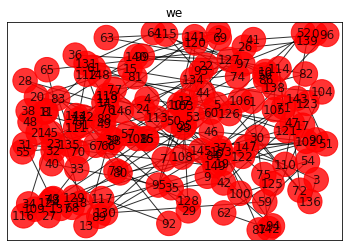

534.8827362139251

In [19]:
draw_tsp_solution(G, result, 'we')
calculate_cost(cost_matrix, result)

# DWave, manual map of Hamiltonian in Ising formulation

In [166]:
## Portfolio

import datetime
import pandas as pd
import pandas_datareader.data as web
from qiskit.finance.data_providers import YahooDataProvider

def covariance(a,b):
    return a.cov(b)

def hi(name, price, returns, cov):

    # mean expected return
    E = np.mean(returns)

    # hi = -(1/2)((1/3)*cov(Ri,Ri) + (1/3)Ai^2 - (1/3)E(Ri) - 2B(1/3)*Ai)
    h_term = -0.5*((1/3)*cov + (1/3)* (Ai ** 2) - (1/3)* E - 2*B*(1/3)*Ai)
    h[name] = h_term

def Ji(name_i, name_j, cov):
    # Ji,j = -(1/4)((1/3)*cov(Ri,Rj) + (1/3)AiAj)
    coupler = -(0.25)*((1/3)*cov + ((1/3)*Ai*Aj))
    J[(name_i, name_j)] = coupler
    
def price_assets(asset, all_data, df):
    df[asset] = all_data
    return df


# Money that can be invested
Ai = 2
Aj = 2
# Total budget
B = 1000000

Ai = 50
Aj = 50
# Total budget
B = 200

#Dictorionary J and h terms
J = {}
h = {}

# Date of assets
start = datetime.datetime(2020,1,1)       
end = datetime.datetime(2021,1,1)

start = datetime.datetime(2018,1,3)       
end = datetime.datetime(2021,1,1)


# Assets to work with
#assets_dict = ['AAPL','IBM','MSFT','GOOGL']
assets_dict = ["AEO", "ABBY", "AEP", "AAL", "GOOG", "IBM"]


data = YahooDataProvider(
                 tickers = assets_dict,
                 start=start,
                 end=end)
data.run()
#for (cnt, s) in enumerate(data._tickers):
#    plt.plot(data._data[cnt], label=s)

#plt.xticks(rotation=90)
#plt.show()
price = pd.DataFrame()
assets = assets_dict
asset_names = assets_dict
cov_assets = {}
cov_assets_coupled = {}

for (cnt, s) in enumerate(data._tickers):
    price[s] = data._data[cnt]

returns_unclean = price.pct_change()
returns = returns_unclean.dropna()


In [167]:
# Covariance of the assets with themselves, 4 items
for i in assets:
    cov = covariance(returns[i], returns[i])
    cov_assets[i] = cov
    
# Covariance of the assets with each other, 6 items
for i in range(len(assets)):
    for j in range(i + 1, len(assets)):
        if j < len(assets):
            cov = covariance(returns[assets[i]], returns[assets[j]])
        else:
            j = 0
            cov = covariance(returns[assets[i]], returns[assets[j]])
        cov_assets_coupled[assets[i],assets[j]] = cov
        
for i in range(len(assets)):
    hi(asset_names[i], price[assets[i]], returns[assets[i]], cov_assets[assets[i]])

for key1, key2 in cov_assets_coupled:
    Ji(key1, key2, cov_assets_coupled[key1,key2])




In [168]:
print(h)
print(J)

{'AAPL': 2916.6668830433214, 'IBM': 2916.6666235372604, 'MSFT': 2916.6668516761993, 'GOOGL': 2916.6667437898436}
{('AAPL', 'IBM'): -208.33335199138872, ('AAPL', 'MSFT'): -208.33336213110476, ('AAPL', 'GOOGL'): -208.33335803992028, ('IBM', 'MSFT'): -208.3333529513306, ('IBM', 'GOOGL'): -208.3333511833141, ('MSFT', 'GOOGL'): -208.33335980507601}


In [169]:

bqm = dimod.BinaryQuadraticModel.from_ising(h,J)
sampleset = dimod.ExactSolver().sample_ising(h,J)
print(sampleset)

   AAPL GOOGL IBM MSFT        energy num_oc.
0    -1    -1  -1   -1 -12916.667238       1
3    -1    -1  +1   -1  -5833.333879       1
15   -1    +1  -1   -1  -5833.333613       1
7    -1    -1  -1   +1  -5833.333385       1
1    +1    -1  -1   -1  -5833.333328       1
12   -1    +1  +1   -1    416.666342       1
4    -1    -1  +1   +1    416.666562       1
2    +1    -1  +1   -1    416.666624       1
8    -1    +1  -1   +1    416.666801       1
14   +1    +1  -1   -1    416.666866       1
6    +1    -1  -1   +1    416.667077       1
11   -1    +1  +1   +1   5833.333344       1
13   +1    +1  +1   -1   5833.333412       1
5    +1    -1  +1   +1   5833.333616       1
9    +1    +1  -1   +1   5833.333831       1
10   +1    +1  +1   +1  10416.666966       1
['SPIN', 16 rows, 16 samples, 4 variables]


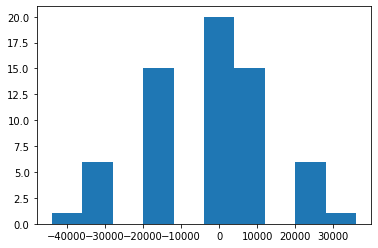

In [133]:
plt.hist(sampleset.record.energy,rwidth=1,align='left')
plt.show()

In [157]:
_, counts = np.unique(sampleset.record.energy.reshape(64,1), axis=0, return_counts=True)
print("Ground state probability: ", counts[0]/runs)


Ground state probability:  0.001


In [170]:
sample = sampleset.first.sample
energy = sampleset.first.energy

print(sample)

# Build solution from returned binary variables:
selected_item_indices = []
for varname, value in sample.items():
    # For each "x" variable, check whether its value is set, which
    # indicates that the corresponding item is included in the
    # knapsack
    if value and varname.startswith('x'):
        # The index into the weight array is retrieved from the
        # variable name
        selected_item_indices.append(int(varname[1:]))

print(sorted(selected_item_indices))

{'AAPL': -1, 'GOOGL': -1, 'IBM': -1, 'MSFT': -1}
[]


In [171]:
sampler = DWaveSampler()
sampler_embedded = EmbeddingComposite(sampler)

runs=200
results = sampler_embedded.sample_ising(h, J, 
    num_reads=runs,
    answer_mode='raw',
    label='Notebook - Anneal Schedule',
    annealing_time=100)

print("QPU time used:", results.info['timing']['qpu_access_time'], "microseconds.")
print(results)

QPU time used: 48755 microseconds.
    AAPL GOOGL IBM MSFT        energy num_oc. chain_.
0     -1    -1  -1   -1 -12916.667238       1     0.0
1     -1    -1  -1   -1 -12916.667238       1     0.0
2     -1    -1  -1   -1 -12916.667238       1     0.0
3     -1    -1  -1   -1 -12916.667238       1     0.0
4     -1    -1  -1   -1 -12916.667238       1     0.0
5     -1    -1  -1   -1 -12916.667238       1     0.0
6     -1    -1  -1   -1 -12916.667238       1     0.0
7     -1    -1  -1   -1 -12916.667238       1     0.0
8     -1    -1  -1   -1 -12916.667238       1     0.0
9     -1    -1  -1   -1 -12916.667238       1     0.0
10    -1    -1  -1   -1 -12916.667238       1     0.0
11    -1    -1  -1   -1 -12916.667238       1     0.0
12    -1    -1  -1   -1 -12916.667238       1     0.0
13    -1    -1  -1   -1 -12916.667238       1     0.0
14    -1    -1  -1   -1 -12916.667238       1     0.0
15    -1    -1  -1   -1 -12916.667238       1     0.0
16    -1    -1  -1   -1 -12916.667238       1  

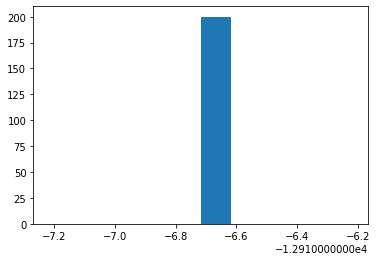

In [172]:
plt.hist(results.record.energy,rwidth=1,align='left')
plt.show()

In [92]:
sampler = LeapHybridSampler()

In [93]:

#bqm = dimod.BQM.from_qubo(qubo)
bqm = dimod.BQM.from_ising(h, J)
print(bqm)
sampleset = sampler.sample(bqm)  

BinaryQuadraticModel({AEO: 13326666.666690769, ABBY: 13326666.662219949, AEP: 13326666.666555317, AAL: 13326666.665899495, GOOG: 13326666.666796234, IBM: 13326666.666603899}, {('AEO', 'ABBY'): -3333.3333177104323, ('AEO', 'AEP'): -3333.33336141882, ('AEO', 'AAL'): -3333.3334487632205, ('AEO', 'GOOG'): -3333.3333672193035, ('AEO', 'IBM'): -3333.333380612476, ('ABBY', 'AEP'): -3333.333350594348, ('ABBY', 'AAL'): -3333.333264913066, ('ABBY', 'GOOG'): -3333.333344374629, ('ABBY', 'IBM'): -3333.3333388126653, ('AEP', 'AAL'): -3333.3333644302957, ('AEP', 'GOOG'): -3333.333356509198, ('AEP', 'IBM'): -3333.333365245412, ('AAL', 'GOOG'): -3333.3333697024514, ('AAL', 'IBM'): -3333.3334038763865, ('GOOG', 'IBM'): -3333.333367389411}, 0, 'SPIN')


# Using Qiskit

In [174]:
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely


In [98]:
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


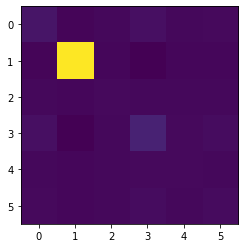

In [99]:
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [151]:
q = 0.5                   # set risk factor
num_assets = len(assets_dict)
budget = num_assets // 2  # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

In [152]:
qubitOp.print_details()

'IIIIIZ\t(1.757434355568262e-05+0j)\nIIIIZI\t(-0.00010577529174114406+0j)\nIIIIZZ\t(2.999953131297392+0j)\nIIIZII\t(-0.0005816143913821526+0j)\nIIIZIZ\t(3.000084256460592+0j)\nIIIZZI\t(3.000051783045009+0j)\nIIZIII\t(-0.0017801420242828988+0j)\nIIZIIZ\t(3.000346289662115+0j)\nIIZIZI\t(2.999794739199894+0j)\nIIZZII\t(3.0000932908874933+0j)\nIZIIII\t(0.00011880215598605154+0j)\nIZIIIZ\t(3.000101657910988+0j)\nIZIIZI\t(3.0000331238878473+0j)\nIZIZII\t(3.0000695275946003+0j)\nIZZIII\t(3.0001091073553994+0j)\nZIIIII\t(-0.0005904520461644275+0j)\nZIIIIZ\t(3.000141837428468+0j)\nZIIIZI\t(3.000016437996014+0j)\nZIIZII\t(3.0000957362376446+0j)\nZIZIII\t(3.0002116291597125+0j)\nZZIIII\t(3.0001021682334064+0j)\n'

In [153]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver

ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()
print('Obj:', result['energy'] + offset)

eigenvalue = ee.compute_minimum_eigenvalue()
print(eigenvalue.eigenvalue)

Obj: -0.001493496366594016
(-9.00321038726405+0j)


In [178]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [155]:
print_result(result)

Optimal: selection [1 1 0 0 1 0], value -0.0015

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 1 0]	-0.0015		1.0000
[1 1 1 1 1 1]	54.0058		0.0000
[0 1 1 1 1 1]	24.0046		0.0000
[1 0 1 1 1 0]	6.0037		0.0000
[0 0 1 1 1 0]	0.0028		0.0000
[1 1 0 1 1 0]	6.0020		0.0000
[0 1 0 1 1 0]	0.0016		0.0000
[1 0 0 1 1 0]	0.0023		0.0000
[0 0 0 1 1 0]	6.0018		0.0000
[1 1 1 0 1 0]	5.9997		0.0000
[0 1 1 0 1 0]	0.0004		0.0000
[1 0 1 0 1 0]	-0.0010		0.0000
[0 0 1 0 1 0]	5.9996		0.0000
[0 1 0 0 1 0]	5.9996		0.0000
[1 0 0 0 1 0]	5.9980		0.0000
[0 0 0 0 1 0]	23.9989		0.0000
[1 1 1 1 0 0]	6.0033		0.0000
[0 1 1 1 0 0]	0.0031		0.0000
[1 0 1 1 0 0]	0.0036		0.0000
[0 0 1 1 0 0]	6.0032		0.0000
[1 1 0 1 0 0]	0.0021		0.0000
[0 1 0 1 0 0]	6.0021		0.0000
[1 0 0 1 0 0]	6.0025		0.0000
[0 0 0 1 0 0]	24.0025		0.0000
[1 1 1 0 0 0]	-0.0000		0.0000
[0 1 1 0 0 0]	6.0011		0.0000
[1 0 1 0 0 0]	5.9994		0.0000
[0 0 1 0 0 0]	24.0004		0.000

Optimal: selection [0 0 0 0 0 0 0 0 0], value 144.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0]	144.0000		1.0000
[0 1 1 1 1 1 1 1 1]	18770.3153		0.0000
[1 0 0 0 0 1 0 1 0]	3243.2905		0.0000
[0 1 0 0 0 1 0 1 0]	3243.3905		0.0000
[1 1 0 0 0 1 0 1 0]	5583.9285		0.0000
[0 0 1 0 0 1 0 1 0]	3243.4005		0.0000
[1 0 1 0 0 1 0 1 0]	5583.9385		0.0000
[0 1 1 0 0 1 0 1 0]	5584.0385		0.0000
[1 1 1 0 0 1 0 1 0]	8786.1261		0.0000
[0 0 0 1 0 1 0 1 0]	3625.1731		0.0000
[1 0 0 1 0 1 0 1 0]	5327.0236		0.0000
[0 1 0 1 0 1 0 1 0]	5327.1236		0.0000
[1 1 0 1 0 1 0 1 0]	7890.5237		0.0000
[0 0 1 1 0 1 0 1 0]	5327.1336		0.0000
[1 0 1 1 0 1 0 1 0]	7890.5337		0.0000
[0 1 1 1 0 1 0 1 0]	7890.6337		0.0000
[1 1 1 1 0 1 0 1 0]	11315.5834		0.0000
[0 0 0 0 1 1 0 1 0]	2879.6192		0.0000
[1 0 0 0 1 1 0 1 0]	4448.9120		0.0000
[0 1 0 0 1 1 0 1 0]	4449.0120		0.0000
[1 1 0 0 1 1 0 1 0]	6879.8543		0.0000
[0 0 1 0 1 1